In [1]:
import os
import numpy as np
import wfdb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, convolve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from dataclasses import dataclass
from typing import List, Tuple

In [2]:
@dataclass
class Config:
    """Proje genelindeki sabitleri tutan konfigürasyon sınıfı."""
    ROOT_PATH: str = r"C:\Users\SGUZEY\Documents\Yüksek Lisans Dersleri\İleri Gömülü Sistemler\Data Sets\mit-bih-arrhythmia-database-1.0.0"
    FS: int = 360
    SEQUENCE_LENGTH: int = 25

    LOW_PASS_CUTOFF: float = 15.0
    HIGH_PASS_CUTOFF: float = 5.0
    BUTTER_ORDER: int = 4

    REGULAR_CLASSES: Tuple[str, ...] = ('N', 'L', 'R', 'e', 'j')

    TEST_SIZE: float = 0.2
    RANDOM_STATE: int = 42
    EPOCHS: int = 50
    BATCH_SIZE: int = 64

In [3]:
class SignalProcessor:
    """Ham EKG sinyallerini işlemek ve görselleştirmek için yardımcı sınıf."""

    def __init__(self, config: Config):
        self.cfg = config

    def _butter_bandpass(self, data: np.ndarray, lowcut: float, highcut: float, order: int = 5) -> np.ndarray:
        nyq = 0.5 * self.cfg.FS
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [high, low], btype='band')
        y = filtfilt(b, a, data)
        return y

    def _find_record_path(self, record_name: str) -> str:
        """Kayıt dosyasının tam yolunu arar ve bulur."""

        direct_path = os.path.join(self.cfg.ROOT_PATH, record_name)
        if os.path.exists(direct_path + '.hea'):
            return direct_path

        for root, dirs, files in os.walk(self.cfg.ROOT_PATH):
            for f in files:
                if f == f"{record_name}.hea":
                    return os.path.join(root, record_name)
        raise FileNotFoundError(f"Kayıt bulunamadı: {record_name}")

    def pan_tompkins_preprocessing(self, signal: np.ndarray) -> dict:
        """Sinyal üzerinde Pan-Tompkins ön işleme adımlarını uygular."""

        filtered = self._butter_bandpass(signal, self.cfg.LOW_PASS_CUTOFF, self.cfg.HIGH_PASS_CUTOFF, self.cfg.BUTTER_ORDER)

        deriv_coeffs = np.array([-1, -2, 0, 2, 1]) / 8.0 * self.cfg.FS
        derivative = convolve(filtered, deriv_coeffs, mode='same')

        squared = derivative ** 2

        window_size = int(0.150 * self.cfg.FS)
        mwi_kernel = np.ones(window_size) / window_size
        mwi = convolve(squared, mwi_kernel, mode='same')

        return {
            "raw": signal,
            "filtered": filtered,
            "derivative": derivative,
            "squared": squared,
            "mwi": mwi
        }

    def plot_record_analysis(self, record_name: str, seconds: int = 10):
        """Belirtilen kaydın sinyal işleme adımlarını çizer."""
        try:

            full_path = self._find_record_path(record_name)
            record = wfdb.rdrecord(full_path)

            sig_idx = 0
            if 'MLII' in record.sig_name:
                sig_idx = record.sig_name.index('MLII')
            elif 'V5' in record.sig_name:
                sig_idx = record.sig_name.index('V5')

            signal = record.p_signal[:, sig_idx]

            process_len = min(len(signal), seconds * self.cfg.FS)
            steps = self.pan_tompkins_preprocessing(signal[:process_len])
            time = np.arange(len(steps['raw'])) / self.cfg.FS

            plt.figure(figsize=(12, 10))

            plt.subplot(4, 1, 1)
            plt.plot(time, steps['raw'], label='Ham Sinyal')
            plt.title(f'{record_name} - Ham Sinyal (Lead {record.sig_name[sig_idx]})')
            plt.legend(loc='upper right')
            plt.grid(True)

            plt.subplot(4, 1, 2)
            plt.plot(time, steps['filtered'], color='orange', label='Filtrelenmiş (5-15Hz)')
            plt.legend(loc='upper right')
            plt.grid(True)

            plt.subplot(4, 1, 3)
            plt.plot(time, steps['squared'], color='green', label='Türev ve Kare Alma')
            plt.legend(loc='upper right')
            plt.grid(True)

            plt.subplot(4, 1, 4)
            plt.plot(time, steps['mwi'], color='red', label='MWI (QRS Zarfı)')
            plt.title('Pan-Tompkins Algoritması Sonucu')
            plt.xlabel('Zaman (s)')
            plt.legend(loc='upper right')
            plt.grid(True)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Görselleştirme hatası ({record_name}): {e}")

In [4]:
class DataLoader:
    """Veri setini okur ve model eğitimi için RR aralıklarını hazırlar."""

    def __init__(self, config: Config):
        self.cfg = config

    def get_record_list(self) -> List[Tuple[str, str]]:
        """Dizin altındaki tüm kayıtları bulur."""
        records = []
        for root, _, files in os.walk(self.cfg.ROOT_PATH):
            for f in files:
                if f.endswith('.hea') and not f.startswith('x_'):
                    rec_name = os.path.splitext(f)[0]
                    records.append((rec_name, root))
        return sorted(list(set(records)))

    def _process_single_record(self, rec_name: str, rec_path: str) -> Tuple[List, List]:
        """Tek bir kaydın RR interval ve etiketlerini çıkarır."""
        try:
            full_path = os.path.join(rec_path, rec_name)
            annotation = wfdb.rdann(full_path, 'atr')
        except Exception as e:
            print(f"Hata ({rec_name}): {e}")
            return [], []

        rr_intervals = np.diff(annotation.sample) / self.cfg.FS

        symbols = annotation.symbol[1:]

        X_seq, y_seq = [], []

        for i in range(len(rr_intervals) - self.cfg.SEQUENCE_LENGTH):
            window_rr = rr_intervals[i : i + self.cfg.SEQUENCE_LENGTH]
            window_sym = symbols[i : i + self.cfg.SEQUENCE_LENGTH]

            if np.min(window_rr) <= 0.2 or np.max(window_rr) >= 2.0:
                continue

            is_irregular = any(sym not in self.cfg.REGULAR_CLASSES for sym in window_sym)
            label = 1 if is_irregular else 0

            X_seq.append(window_rr)
            y_seq.append(label)

        return X_seq, y_seq

    def create_dataset(self) -> Tuple[np.ndarray, np.ndarray]:
        """Tüm kayıtları işler ve X, y matrislerini döner."""
        records = self.get_record_list()
        print(f"Toplam {len(records)} kayıt işleniyor...")

        all_X, all_y = [], []
        for name, path in records:
            X_rec, y_rec = self._process_single_record(name, path)
            all_X.extend(X_rec)
            all_y.extend(y_rec)

        return np.array(all_X), np.array(all_y)

In [5]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape


class ArrhythmiaModel:
    """Yapay Sinir Ağı modelinin oluşturulması, eğitilmesi ve değerlendirilmesi."""

    def __init__(self, config: Config, input_shape: Tuple[int]):
        self.cfg = config
        self.input_shape = input_shape
        self.model = self._build_model()

    def _build_model(self) -> Sequential:
        model = Sequential([
            Input(shape=self.input_shape),

            Reshape((self.cfg.SEQUENCE_LENGTH, 1)),

            Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),

            Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),

            Flatten(),

            Dense(32, activation='relu'),
            Dropout(0.2),

            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, X_val, y_val, class_weights=None):
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
            ModelCheckpoint('best_arrhythmia_model.keras', save_best_only=True, monitor='val_loss')
        ]

        history = self.model.fit(
            X_train, y_train,
            epochs=self.cfg.EPOCHS,
            batch_size=self.cfg.BATCH_SIZE,
            validation_data=(X_val, y_val),
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=2
        )
        return history

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)

        print("\n" + "="*30)
        print("SINIFLANDIRMA RAPORU")
        print("="*30)
        print(classification_report(y_test, y_pred, target_names=['Düzenli', 'Düzensiz']))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Düzenli', 'Düzensiz'],
                    yticklabels=['Düzenli', 'Düzensiz'])
        plt.title('Confusion Matrix')
        plt.ylabel('Gerçek')
        plt.xlabel('Tahmin')
        plt.show()

--- Sinyal Analizi Örneği Çiziliyor ---


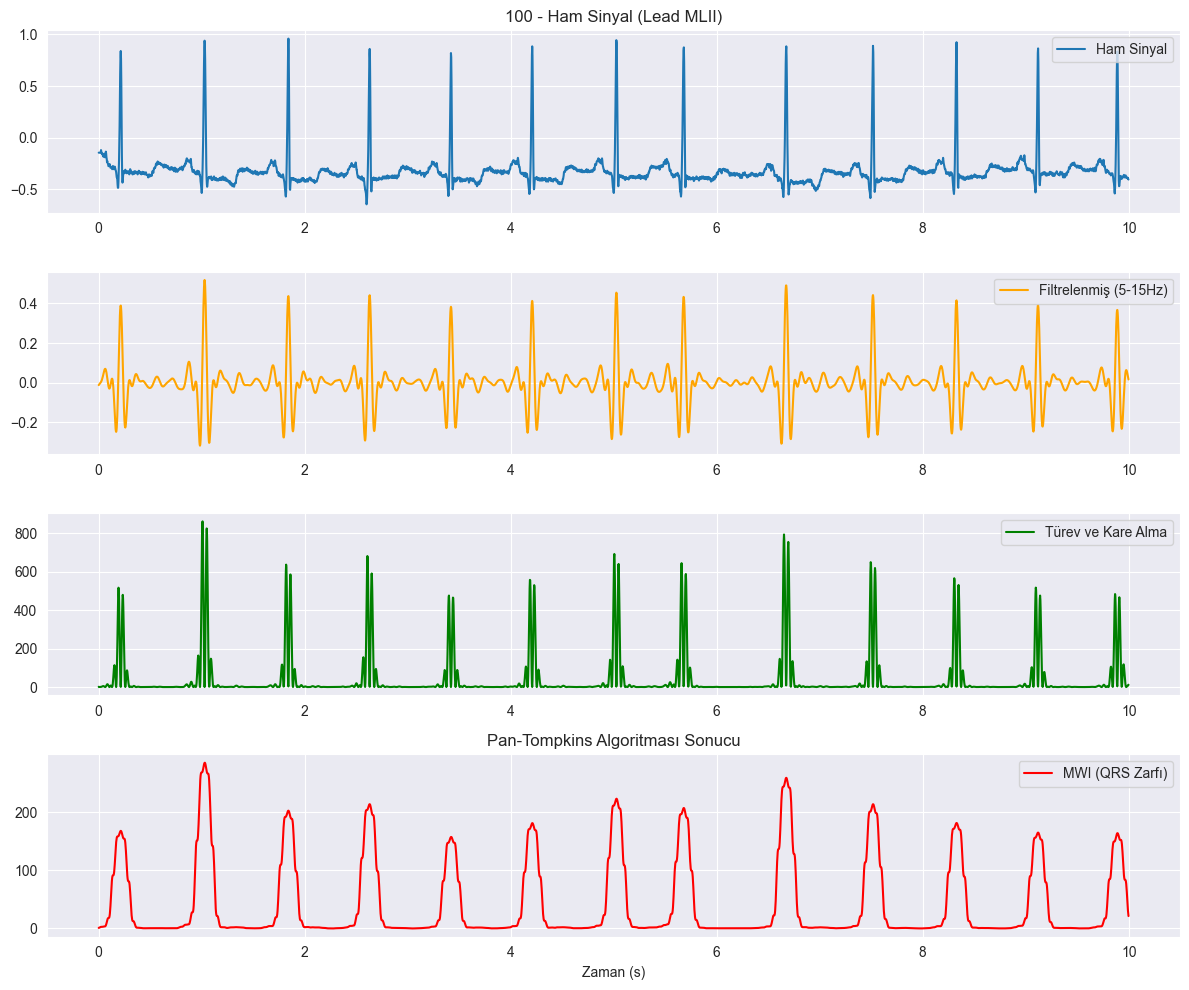


--- Veri Seti Hazırlanıyor ---
Toplam 48 kayıt işleniyor...
Toplam Örnek: 101491
Sınıf Dağılımı: Normal=45963, Düzensiz=55528
Sınıf Ağırlıkları: {0: 1.1040522164808269, 1: 0.9138715051100806}

--- Model Eğitimi Başlıyor ---
Epoch 1/50
1269/1269 - 14s - loss: 0.3031 - accuracy: 0.8691 - val_loss: 0.2102 - val_accuracy: 0.9132 - 14s/epoch - 11ms/step
Epoch 2/50
1269/1269 - 5s - loss: 0.2209 - accuracy: 0.9045 - val_loss: 0.2143 - val_accuracy: 0.9101 - 5s/epoch - 4ms/step
Epoch 3/50
1269/1269 - 5s - loss: 0.2048 - accuracy: 0.9112 - val_loss: 0.2668 - val_accuracy: 0.9058 - 5s/epoch - 4ms/step
Epoch 4/50
1269/1269 - 5s - loss: 0.1968 - accuracy: 0.9165 - val_loss: 0.1696 - val_accuracy: 0.9298 - 5s/epoch - 4ms/step
Epoch 5/50
1269/1269 - 5s - loss: 0.1883 - accuracy: 0.9192 - val_loss: 0.1821 - val_accuracy: 0.9242 - 5s/epoch - 4ms/step
Epoch 6/50
1269/1269 - 5s - loss: 0.1840 - accuracy: 0.9228 - val_loss: 0.1726 - val_accuracy: 0.9286 - 5s/epoch - 4ms/step
Epoch 7/50
1269/1269 - 5s - 

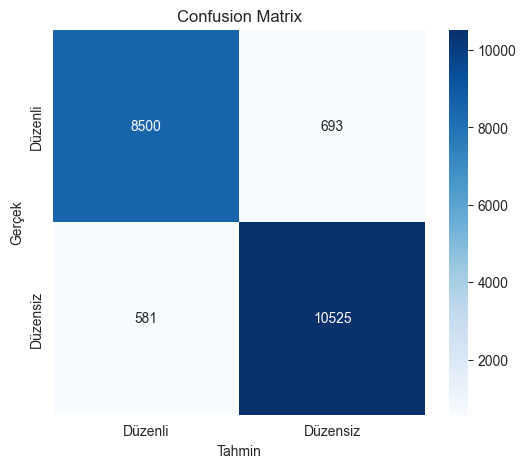

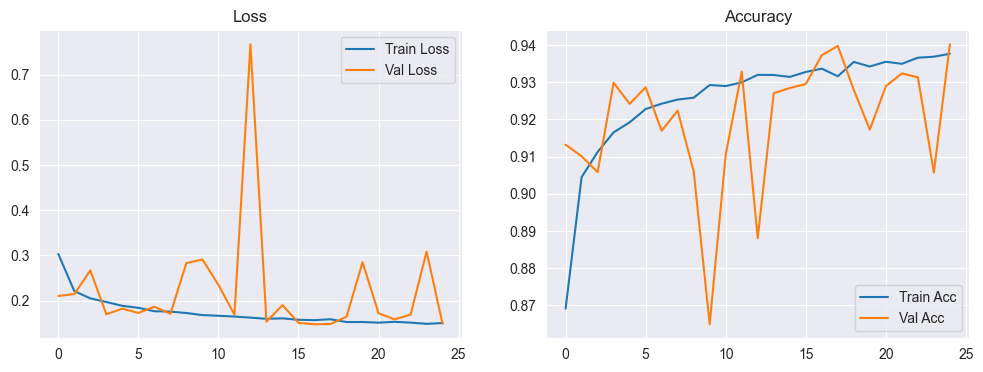

In [6]:
def main():
    # 1. Ayarları Yükle
    cfg = Config()

    # 2. (Opsiyonel) Sinyal İşlemeyi Test Et / Görselleştir
    # Örnek olarak '100' numaralı kaydın ilk 10 saniyesini çizdirir.
    print("--- Sinyal Analizi Örneği Çiziliyor ---")
    processor = SignalProcessor(cfg)
    processor.plot_record_analysis("100", seconds=10)

    # 3. Veri Setini Hazırla
    print("\n--- Veri Seti Hazırlanıyor ---")
    loader = DataLoader(cfg)
    X, y = loader.create_dataset()

    if len(X) == 0:
        print("HATA: Veri seti oluşturulamadı. Dosya yolunu kontrol edin.")
        return

    print(f"Toplam Örnek: {len(X)}")
    print(f"Sınıf Dağılımı: Normal={np.sum(y==0)}, Düzensiz={np.sum(y==1)}")

    # 4. Eğitim/Test Ayrımı
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=cfg.TEST_SIZE, random_state=cfg.RANDOM_STATE, stratify=y
    )

    # 5. Sınıf Ağırlıklarını Hesapla (Dengesiz veri seti için)
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    weight_dict = dict(enumerate(weights))
    print(f"Sınıf Ağırlıkları: {weight_dict}")

    # 6. Modeli Kur ve Eğit
    print("\n--- Model Eğitimi Başlıyor ---")
    model_wrapper = ArrhythmiaModel(cfg, input_shape=(cfg.SEQUENCE_LENGTH,))

    history = model_wrapper.train(X_train, y_train, X_test, y_test, class_weights=weight_dict)

    # 7. Sonuçları Değerlendir
    model_wrapper.evaluate(X_test, y_test)

    # 8. Eğitim Geçmişini Çiz
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [7]:
import tensorflow as tf
import tf2onnx

model = tf.keras.models.load_model('best_arrhythmia_model.keras')

spec = (tf.TensorSpec((None, 25), tf.float32, name="input"),)

output_path = "model.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)

with open(output_path, "wb") as f:
    f.write(model_proto.SerializeToString())

print("Model başarıyla model.onnx olarak kaydedildi!")

Model başarıyla model.onnx olarak kaydedildi!
